In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from models.lstm import LSTMRegressor
from models.kan_encoder import KANEncoder
from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
window_size = 7
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 32,
        "num_layers": 1,
        "dropout": 0.30509031870364545,
        "batch_size": 32,
        "lr": 0.0003989560669109018
    },
    StockIndex.AAPL: {
        "hidden_dim": 64,
        "num_layers": 2,
        "dropout": 0.4631104642845718,
        "batch_size": 32,
        "lr": 0.0007686076135048239
    },
    StockIndex.KO: {
        "hidden_dim": 256,
        "num_layers": 3,
        "dropout": 0.24565496824623936,
        "batch_size": 16,
        "lr": 0.0011359834976379637
    }
}

BEST_KAN_PARAMS = {
    StockIndex.NVDA: {
        "kan_hidden_dim": 6,
        "encoded_dim": 8,
        "grid": 9,
        "k": 6,
        "lambda_reg": 0.0004458266419066633,
        "lamb_entropy": 0.717720236975619,
        "lamb_l1": 1.149059078087476,
        "lr": 0.00012316992246152894
    },
    StockIndex.AAPL: {
        "kan_hidden_dim": 7,
        "encoded_dim": 32,
        "grid": 7,
        "k": 5,
        "lambda_reg": 5.1354541183480174e-05,
        "lamb_entropy": 0.521344954746289,
        "lamb_l1": 0.6737197364706,
        "lr": 0.008925756624083675
    },
    StockIndex.KO: {
        "kan_hidden_dim": 5,
        "encoded_dim": 8,
        "grid": 7,
        "k": 3,
        "lambda_reg": 8.326365705391409e-05,
        "lamb_entropy": -.43587275706317835,
        "lamb_l1": 0.3356332324508783,
        "lr": 0.0004550557623610961
    }
}


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Training KAN -> LSTM for each stock ##

### NVIDIA ###
Avg Val Loss in Tuning 0.004144

In [3]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.036423922404646876
Epoch 2: Train=0.03385598864406347
Epoch 3: Train=0.02310137906111777
Epoch 4: Train=0.0033734245190862565
Epoch 5: Train=0.001021243626018986
Epoch 6: Train=0.0006440873577957973
Epoch 7: Train=0.0005190576030872763
Epoch 8: Train=0.0004603026539552957
Epoch 9: Train=0.0004126109721255489
Epoch 10: Train=0.00038371001777704806
Epoch 11: Train=0.00035524110076949
Epoch 12: Train=0.00034618251636857165
Epoch 13: Train=0.00031537375412881373
Epoch 14: Train=0.0003167671294067986
Epoch 15: Train=0.00029234994188300336
Epoch 16: Train=0.0002689260712941177
Epoch 17: Train=0.0002701751599670388
Epoch 18: Train=0.0002571670171164442
Epoch 19: Train=0.00023592375000589528
Epoch 20: Train=0.0002265145134879276
Epoch 21: Train=0.0002203989888948854
Epoch 22: Train=0.00021656835277099164
Epoch 23: Train=0.00022840256249764934
Epoch 24: Train=0.00022043029675842263
Epoch 25: Train=0.0002030546116293408
Epoch 26: Train=0.0002124262116558384
Epoch 27: Train=0.000

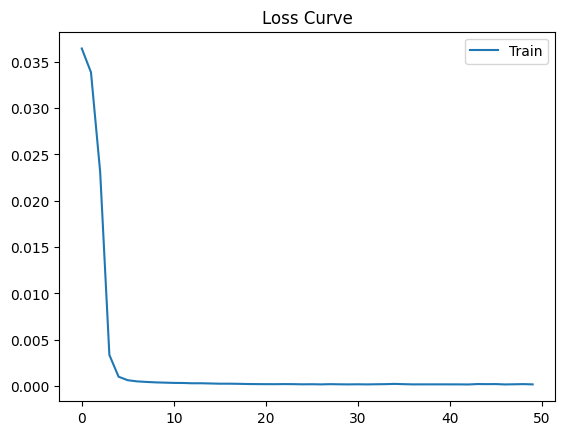

In [4]:
nvda_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

nvda_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': nvda_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = nvda_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 11.0265
Test MAE : 8.5249


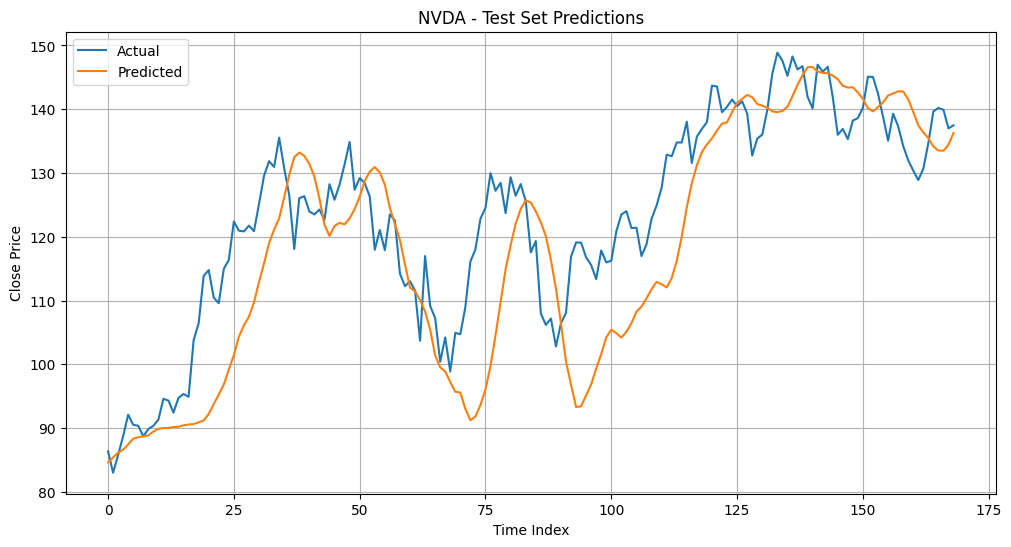

Actual Volatility (std of returns): 0.0328
Predicted Volatility             : 0.0179


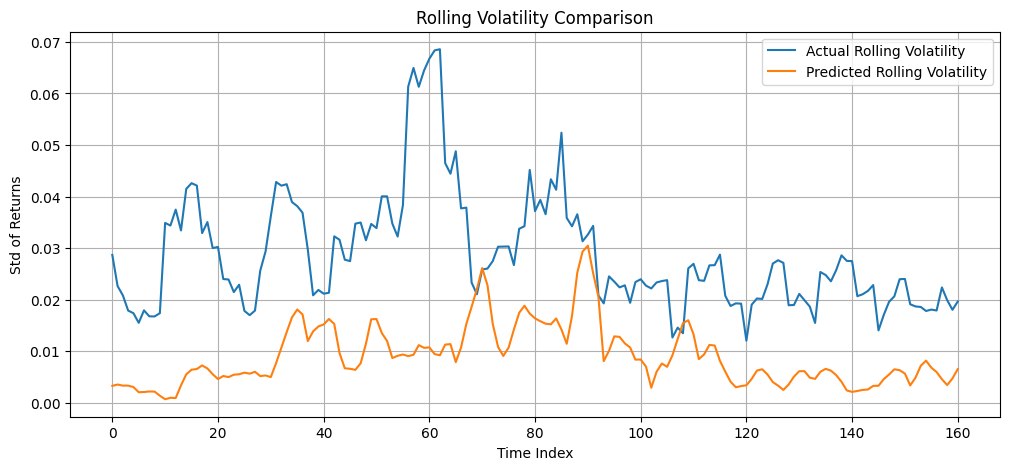

In [5]:
# Ensure both models are in eval mode
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)             # [B, T, D]
        pred = nvda_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
nvda_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
nvda_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(nvda_targets_unscaled, nvda_preds_unscaled))
mae = mean_absolute_error(nvda_targets_unscaled, nvda_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(nvda_targets_unscaled, label="Actual")
plt.plot(nvda_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(nvda_targets_unscaled) / nvda_targets_unscaled[:-1]
pred_returns   = np.diff(nvda_preds_unscaled) / nvda_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Apple ###
Avg Val Loss in Tuning 0.000328

In [6]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.10024379943730309
Epoch 2: Train=0.003103185825748369
Epoch 3: Train=0.0017239628918468953
Epoch 4: Train=0.0014447424199897797
Epoch 5: Train=0.0011044481670251117
Epoch 6: Train=0.0010950495675206185
Epoch 7: Train=0.0009844684996642172
Epoch 8: Train=0.0009549271492869594
Epoch 9: Train=0.0008356544535490684
Epoch 10: Train=0.0008643907360965386
Epoch 11: Train=0.0007998046657303348
Epoch 12: Train=0.0008251937024760991
Epoch 13: Train=0.0009322887490270659
Epoch 14: Train=0.0007737341197207571
Epoch 15: Train=0.000758814579457976
Epoch 16: Train=0.0007783207145985216
Epoch 17: Train=0.000646110973902978
Epoch 18: Train=0.0006568965321639553
Epoch 19: Train=0.0006527102028485388
Epoch 20: Train=0.0006394238834036514
Epoch 21: Train=0.0006621608440764248
Epoch 22: Train=0.000754235737840645
Epoch 23: Train=0.0006293482048204169
Epoch 24: Train=0.0005826813448220491
Epoch 25: Train=0.0005751174699980766
Epoch 26: Train=0.0007593013896257617
Epoch 27: Train=0.000578901

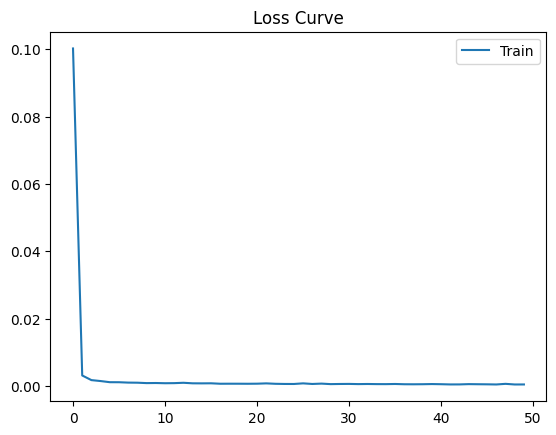

In [7]:
aapl_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

aapl_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': aapl_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = aapl_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 19.4330
Test MAE : 14.9576


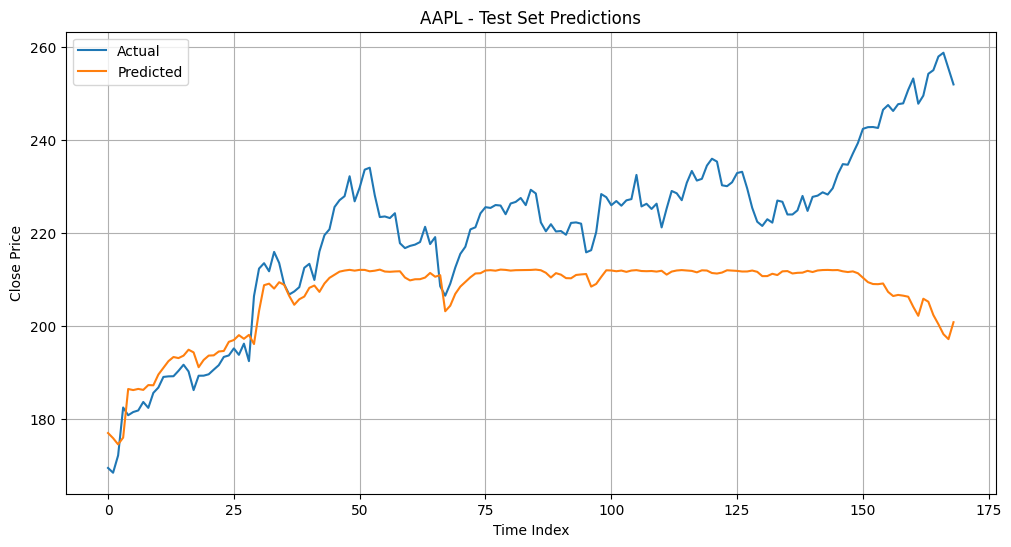

Actual Volatility (std of returns): 0.0145
Predicted Volatility             : 0.0081


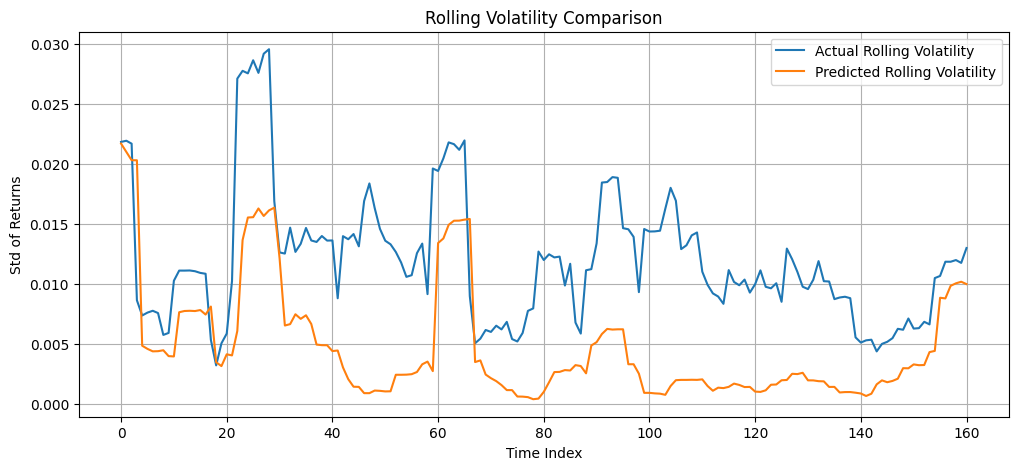

In [8]:
# Ensure both models are in eval mode
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)             # [B, T, D]
        pred = aapl_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
aapl_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
aapl_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(aapl_targets_unscaled, aapl_preds_unscaled))
mae = mean_absolute_error(aapl_targets_unscaled, aapl_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(aapl_targets_unscaled, label="Actual")
plt.plot(aapl_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(aapl_targets_unscaled) / aapl_targets_unscaled[:-1]
pred_returns   = np.diff(aapl_preds_unscaled) / aapl_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Coke ###
Avg Val Loss in Tuning 0.000331

In [9]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.04379722530803069
Epoch 2: Train=0.003381059046439601
Epoch 3: Train=0.0024035897639796437
Epoch 4: Train=0.0018746422108667292
Epoch 5: Train=0.0018700274704682707
Epoch 6: Train=0.001684059069087409
Epoch 7: Train=0.0017392841044865134
Epoch 8: Train=0.0017557808958262092
Epoch 9: Train=0.0013753039911718605
Epoch 10: Train=0.001753456184153699
Epoch 11: Train=0.0013581945108440282
Epoch 12: Train=0.001331224493421332
Epoch 13: Train=0.0011101902454898626
Epoch 14: Train=0.0012828861992345239
Epoch 15: Train=0.0011593056151836245
Epoch 16: Train=0.001449018562767617
Epoch 17: Train=0.0011112866053037873
Epoch 18: Train=0.0009838690965982022
Epoch 19: Train=0.0009267688017441995
Epoch 20: Train=0.0009210370433977758
Epoch 21: Train=0.000856686629177979
Epoch 22: Train=0.000965085483539492
Epoch 23: Train=0.0008982703368405275
Epoch 24: Train=0.0007679874068325988
Epoch 25: Train=0.0007700813965662618
Epoch 26: Train=0.0007495180703111633
Epoch 27: Train=0.000741663680

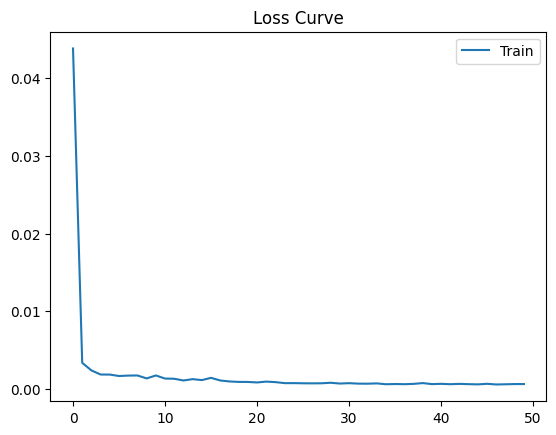

In [10]:
ko_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

ko_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': ko_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float("inf")
best_model_state = None

for epoch in range(50):
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = ko_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 6.0830
Test MAE : 4.7587


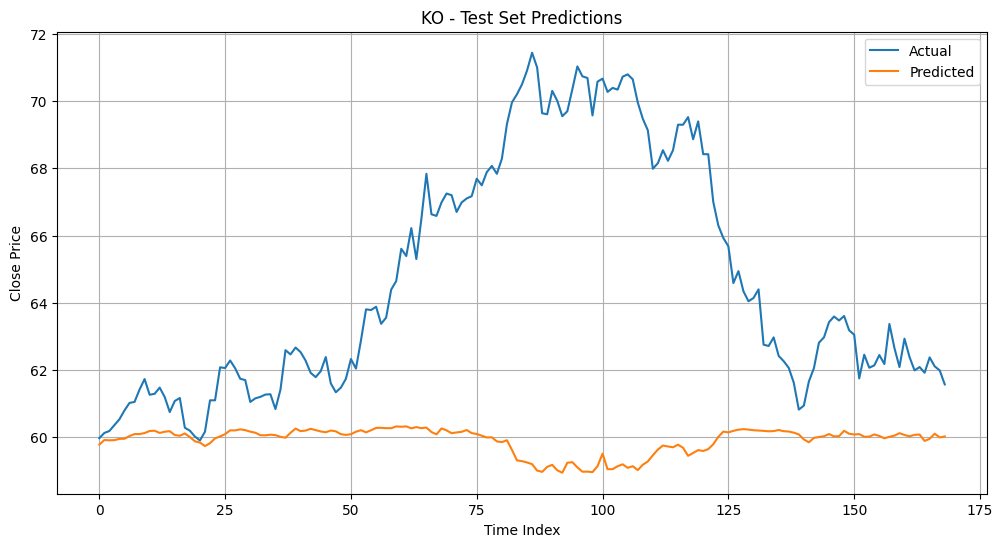

Actual Volatility (std of returns): 0.0083
Predicted Volatility             : 0.0017


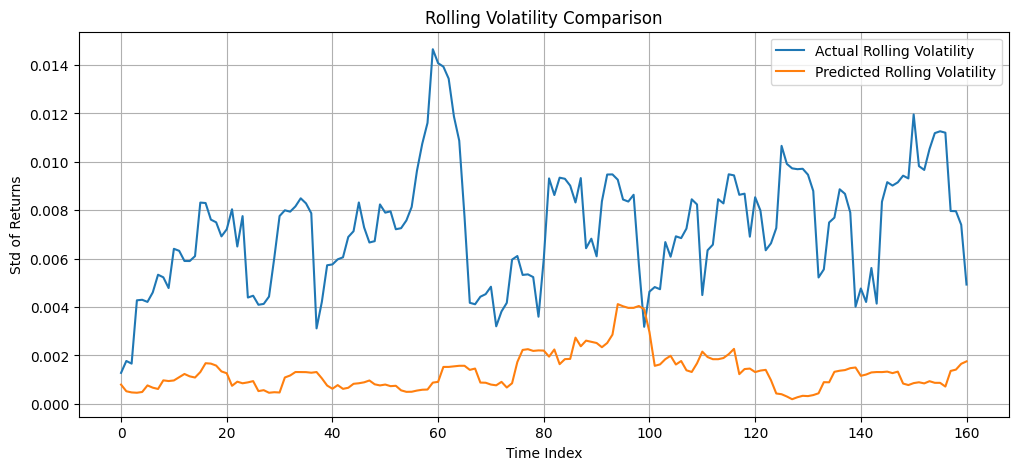

In [11]:
# Ensure both models are in eval mode
ko_encoder.eval()
ko_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)             # [B, T, D]
        pred = ko_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
ko_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
ko_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(ko_targets_unscaled, ko_preds_unscaled))
mae = mean_absolute_error(ko_targets_unscaled, ko_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(ko_targets_unscaled, label="Actual")
plt.plot(ko_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(ko_targets_unscaled) / ko_targets_unscaled[:-1]
pred_returns   = np.diff(ko_preds_unscaled) / ko_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()